# The Parcels Kernel loop


This tutorial explains how Parcels executes multiple Kernels, and what happens under the hood when you combine Kernels. 

This is probably not very relevant when you only use the built-in Advection kernels, but can be important when you are writing and combining your own Kernels!

## Background

When you run a Parcels simulation (i.e. a call to `pset.execute()`), the Kernel loop is the main part of the code that is executed. This part of the code loops through all particles and executes the Kernels that are defined for each particle.

In order to make sure that the displacements of a particle in the different Kernels can be summed, all Kernels add to a _change_ in position. This is important, because there are situations where movement kernels would otherwise not commute. Take the example of advecting particles by currents _and_ winds. If the particle would first be moved by the currents and then by the winds, the result could be different from first moving by the winds and then by the currents. Instead, by adding the changes in position, the ordering of the Kernels has no consequence on the particle displacement.

## Basic implementation

Below is a structured overview of the Kernel loop is implemented. Note that this is for longitude only, but the same process is applied for latitude and depth.

1. Define an extra variable `particle.lon_nextloop` for each particle, which is the longitude at the end of the Kernel loop. Inititalise it to `particle.lon`.

2. Also define an extra variable `particle.time_nextloop` for each particle, which is the time at the end of the Kernel loop. Inititalise it to `particle.time`.

3. Within the Kernel loop, for each particle:<br>

    1. Update `particle.lon` with `particle.lon_nextloop`<br>

    2. Update `particle.time` with `particle.time_nextloop`<br>

    3. Set local variable `particle_dlon = 0`<br>

    4. For each Kernel in the list of Kernels:
        
        1. Execute the Kernel
        
        2. Update `particle_dlon` by adding the change in longitude, if needed<br>

    5. Update `particle.lon_nextloop` with `particle.lon + particle_dlon`<br>
    
    6. Update `particle.time_nextloop` with `particle.time + particle.dt`<br>

    7. If `outputdt` is a multiple of `particle.time`, write `particle.lon` and `particle.time` to zarr output file<br>

Besides having commutable Kernels, the main advantage of this implementation is that, when using Field Sampling with e.g. `particle.temp = fieldset.Temp[particle.time, particle.depth, particle.lat, particle.lon]`, the particle location stays the same throughout the entire Kernel loop. Additionally, this implementation ensures that the particle location is the same as the location of the sampled field in the output file.

## Example use

Below is a simple example of some particles at the surface of the ocean. We create an idealised zonal wind flow that will "push" a particle that is already affected by the surface currents.

In [1]:
from datetime import timedelta

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from parcels import (
    AdvectionRK4,
    Field,
    FieldSet,
    JITParticle,
    ParticleSet,
    download_example_dataset,
)

# Load the GlobCurrent data in the Agulhas region from the example_data
example_dataset_folder = download_example_dataset("GlobCurrent_example_data")
filenames = {
    "U": f"{example_dataset_folder}/20*.nc",
    "V": f"{example_dataset_folder}/20*.nc",
}
variables = {
    "U": "eastward_eulerian_current_velocity",
    "V": "northward_eulerian_current_velocity",
}
dimensions = {"lat": "lat", "lon": "lon", "time": "time"}
fieldset = FieldSet.from_netcdf(filenames, variables, dimensions)
# uppermost layer in the hydrodynamic data
fieldset.mindepth = fieldset.U.depth[0]

In [2]:
# Create an idealised wind field and add it to the fieldset
xdim, ydim = (len(fieldset.U.lon), len(fieldset.U.lat))
UWind = Field(
    "UWind",
    np.ones((ydim, xdim), dtype=np.float32) * np.sin(fieldset.U.lat)[:, None],
    lon=fieldset.U.lon,
    lat=fieldset.U.lat,
    mesh="spherical",
    fieldtype="U",
)
VWind = Field(
    "VWind", np.zeros((ydim, xdim), dtype=np.float32), grid=UWind.grid, fieldtype="V"
)
fieldset_wind = FieldSet(UWind, VWind)

fieldset.add_field(fieldset_wind.U, name="UWind")
fieldset.add_field(fieldset_wind.V, name="VWind")

Now define a wind kernel that uses a forward Euler method to apply the wind forcing. Note that we update the `particle_dlon` and `particle_dlat` variables, rather than `particle.lon` and `particle.lat` directly.

In [3]:
def wind_kernel(particle, fieldset, time):
    particle_dlon += (
        fieldset.UWind[time, particle.depth, particle.lat, particle.lon] * particle.dt
    )
    particle_dlat += (
        fieldset.VWind[time, particle.depth, particle.lat, particle.lon] * particle.dt
    )

Run a simulation where we apply first kernels as `[AdvectionRK4, wind_kernel]`

In [4]:
lons = 26.0 * np.ones(10)
lats = np.linspace(-37.5, -34.5, 10)

pset = ParticleSet(fieldset, pclass=JITParticle, lon=lons, lat=lats)
output_file = pset.ParticleFile(
    name="advection_then_wind.zarr", outputdt=timedelta(hours=6)
)
pset.execute(
    [AdvectionRK4, wind_kernel],
    runtime=timedelta(days=5),
    dt=timedelta(hours=1),
    output_file=output_file,
)

INFO: Output files are stored in advection_then_wind.zarr.
100%|██████████| 432000.0/432000.0 [00:00<00:00, 1059409.81it/s]


And also run a simulation where we apply the kernels in the reverse order as `[wind_kernel, AdvectionRK4]`

In [5]:
pset_reverse = ParticleSet(fieldset, pclass=JITParticle, lon=lons, lat=lats)
output_file_reverse = pset_reverse.ParticleFile(
    name="wind_then_advection.zarr", outputdt=timedelta(hours=6)
)
pset_reverse.execute(
    [wind_kernel, AdvectionRK4],
    runtime=timedelta(days=5),
    dt=timedelta(hours=1),
    output_file=output_file_reverse,
)

INFO: Output files are stored in wind_then_advection.zarr.
100%|██████████| 432000.0/432000.0 [00:00<00:00, 1317764.47it/s]


Finally, plot the trajectories to show that they are identical in the two simulations.

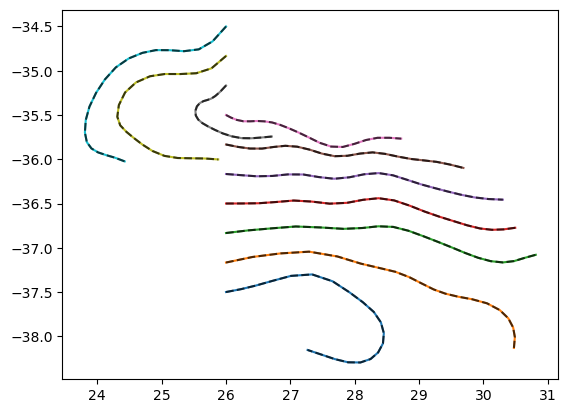

In [6]:
# Plot the resulting particle trajectories overlapped for both cases
advection_then_wind = xr.open_zarr("advection_then_wind.zarr")
wind_then_advection = xr.open_zarr("wind_then_advection.zarr")
plt.plot(wind_then_advection.lon.T, wind_then_advection.lat.T, "-")
plt.plot(advection_then_wind.lon.T, advection_then_wind.lat.T, "--", c="k", alpha=0.7)
plt.show()

## Caveats

There are a few important considerations to take into account when writing Kernels

### 1. Avoid updating particle locations directly in Kernels
It is better not to update `particle.lon` directly in a Kernel, as it can interfere with the loop above. Assigning a value to `particle.lon` in a Kernel will throw a warning. 

Instead, update the local variable `particle_dlon`.

### 2. Be careful with updating particle variables that do not depend on Fields.
While assigning the interpolated value of a `Field` to a Particle goes well in the loop above, this is not necessarily so for assigning other attributes. For example, a line like `particle.age += particle.dt` is executed directly so may result in the age being `dt` at `time = 0` in the output file. 

A workaround is to either initialise the age to `-dt`, or to increase the `age` only when `particle.time > 0` (using an `if` statement).


### 3. The last time is not written to file
Because the location at the start of the loop is written at the end of the Kernel loop, the last `particle.time` of the particle is not written to file. This is similar behaviour to e.g. `np.arange(start, stop)`, which also doesn't include the `stop` value itself. 

If you do want to write the last time to file, you can increase the `runtime` or `endtime` by `dt` (although this may cause a TimeExtrapolationError if your run was to the end of the available hydrodynamic data), or you can call `pfile.write_latest_locations(pset, time=endtime)`. Note that in the latter case, the particle locations (longitude, latitude and depth) will be updated, but other variables will _not_ be updated as the Kernels are not run again.

## Working with Status Codes

In order to capture errors in the Kernel loop, Parcels uses a Status Code system. There are several Status Codes, listed below.

In [7]:
from parcels import StatusCode

for statuscode, val in StatusCode.__dict__.items():
    if statuscode.startswith("__"):
        continue
    print(f"{statuscode} = {val}")

Success = 0
Evaluate = 10
Repeat = 20
Delete = 30
StopExecution = 40
StopAllExecution = 41
Error = 50
ErrorInterpolation = 51
ErrorOutOfBounds = 60
ErrorThroughSurface = 61
ErrorTimeExtrapolation = 70


Once an error is thrown (for example, a Field Interpolation error), then the `particle.state` is updated to the corresponding status code. This gives you the flexibility to write a Kernel that checks for a status code and does something with it. 

For example, you can write a Kernel that checks for `particle.state == StatusCode.ErrorOutOfBounds` and deletes the particle, and then append this to the Kernel list in `pset.execute()`.

In [8]:
def CheckOutOfBounds(particle, fieldset, time):
    if particle.state == StatusCode.ErrorOutOfBounds:
        particle.delete()


def CheckError(particle, fieldset, time):
    if particle.state >= 50:  # This captures all Errors
        particle.delete()

But of course, you can also write code for more sophisticated behaviour than just deleting the particle. It's up to you! Note that if you don't delete the particle, you will have to update the `particle.state = StatusCode.Success` yourself. For example:

In [9]:
def Move1DegreeWest(particle, fieldset, time):
    if particle.state == StatusCode.ErrorOutOfBounds:
        particle_dlon -= 1.0
        particle.state = StatusCode.Success

Or, if you want to make sure that particles don't escape through the water surface

In [10]:
def KeepInOcean(particle, fieldset, time):
    if particle.state == StatusCode.ErrorThroughSurface:
        particle_ddepth = 0.0
        particle.state = StatusCode.Success

Kernel functions such as the ones above can then be added to the list of kernels in `pset.execute()`.